# "TabularPandas on Titanic dataset."

> "Create a Learner, TabularPandas on Titanic's dataset."

- toc: true
- branch: master
- comments : False
- author : Eric Vincent
- categories : [fastpages, jupyter]

In [1]:
#hide
import os
from pathlib import Path
creds = '{"username":"ericvincent18","key":"e4acd0ae64ec375a76a571db9511fc28"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [2]:
#hide
!pip install kaggle

In [3]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [4]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [5]:
!pip install fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
import torch.nn.functional as F

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 12.2 MB/s eta 0:00:00


In [6]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [7]:
df = pd.read_csv(path/'train.csv')

In [8]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

In [10]:
df.groupby('Sex')['Fare'].mean()

Sex
female   44.48
male     25.52
Name: Fare, dtype: float64

In [11]:
splits = RandomSplitter(seed=42)(df)

In [12]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

In [13]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.05754399299621582, valley=0.013182567432522774)

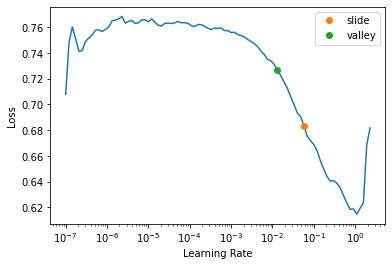

In [14]:
# suggest a learning rate using fastai's lr_find function
learn.lr_find(suggest_funcs=(slide, valley))